Traditional Method

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tiktok_google_play_reviews.csv to tiktok_google_play_reviews.csv


In [ ]:
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt

df = pd.read_csv('tiktok_google_play_reviews.csv')[['content', 'score']]
df.dropna(inplace=True)
df = df.head(10000)

/tmp/ipython-input-13-2197871473.py:6: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tiktok_google_play_reviews.csv')[['content', 'score']]


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    stopwords = set([
        'the','and','is','in','to','of','for','on','a','an','this','that','it','with','as',
        'was','but','are','have','not','be','my','at','so','if','me','they','just','do','or','its','you'
    ])
    return " ".join([w for w in text.split() if w not in stopwords])

df['cleaned_content'] = df['content'].apply(clean_text)

In [ ]:
# Feature engineering
df['review_length'] = df['cleaned_content'].apply(len)
df['word_count'] = df['cleaned_content'].apply(lambda x: len(x.split()))
df['polarity'] = df['cleaned_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

def get_sentiment(p):
    if p > 0.1:
        return 'Positive'
    elif p < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['polarity'].apply(get_sentiment)

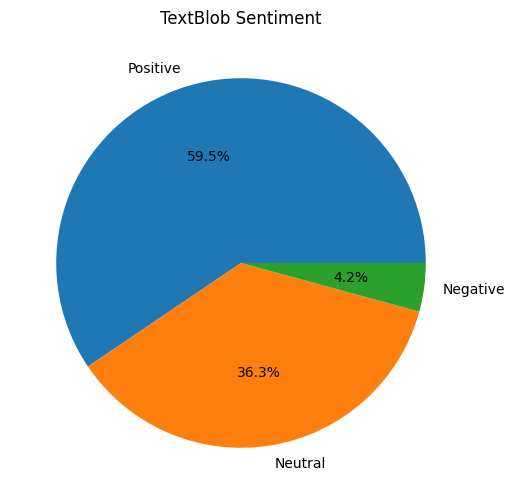

In [ ]:
# Basic visualization
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6), title="TextBlob Sentiment")
plt.ylabel('')
plt.show()

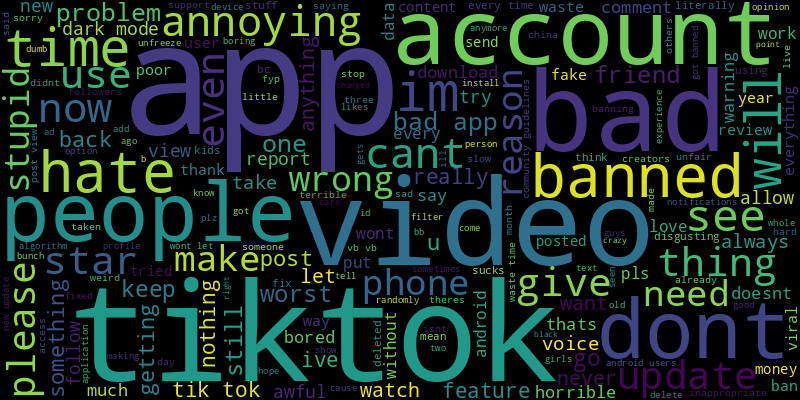

In [ ]:
# Word clouds
from wordcloud import WordCloud

positive_words = ' '.join(df[df['sentiment']=='Positive']['cleaned_content'])
negative_words = ' '.join(df[df['sentiment']=='Negative']['cleaned_content'])

WordCloud(width=800, height=400).generate(positive_words).to_image()
WordCloud(width=800, height=400).generate(negative_words).to_image()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.15      0.25        89
    Positive       0.94      1.00      0.97      1186

    accuracy                           0.94      1275
   macro avg       0.97      0.57      0.61      1275
weighted avg       0.94      0.94      0.92      1275



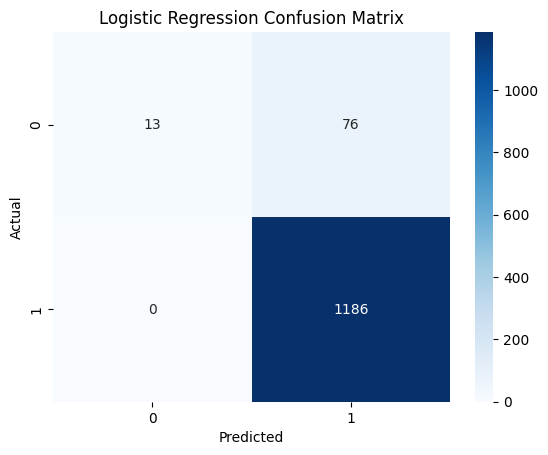


SVM (Linear) Classification Report:
              precision    recall  f1-score   support

    Negative       0.93      0.61      0.73        89
    Positive       0.97      1.00      0.98      1186

    accuracy                           0.97      1275
   macro avg       0.95      0.80      0.86      1275
weighted avg       0.97      0.97      0.97      1275



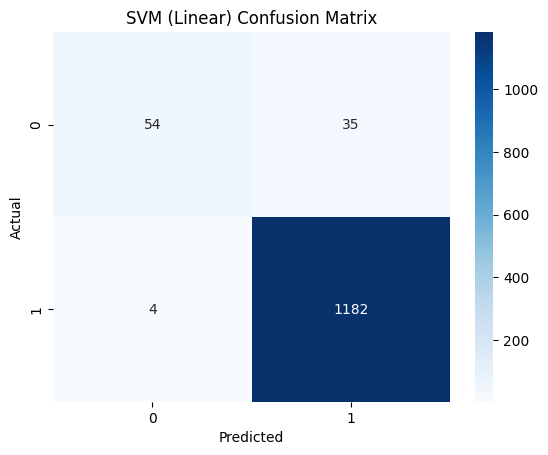


Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.43      0.59        89
    Positive       0.96      1.00      0.98      1186

    accuracy                           0.96      1275
   macro avg       0.95      0.71      0.78      1275
weighted avg       0.96      0.96      0.95      1275



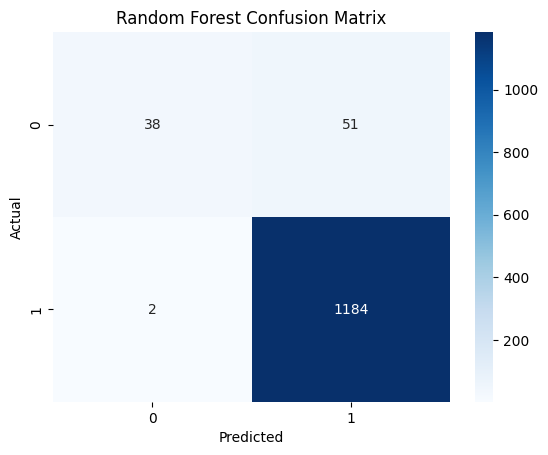

In [ ]:
# 1. Setup: Import additional libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 2. Prepare dataset
df_model = df[df['sentiment'] != 'Neutral']  # Remove Neutral for binary classification
X = df_model['cleaned_content']
y = df_model['sentiment'].map({'Positive': 1, 'Negative': 0})  # Convert to binary labels

# 3. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 5. Train models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds, target_names=['Negative', 'Positive']))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative      0.833     0.156     0.263        96
     Neutral      0.822     0.957     0.884       693
    Positive      0.965     0.936     0.951      1211

    accuracy                          0.906      2000
   macro avg      0.873     0.683     0.699      2000
weighted avg      0.909     0.906     0.894      2000



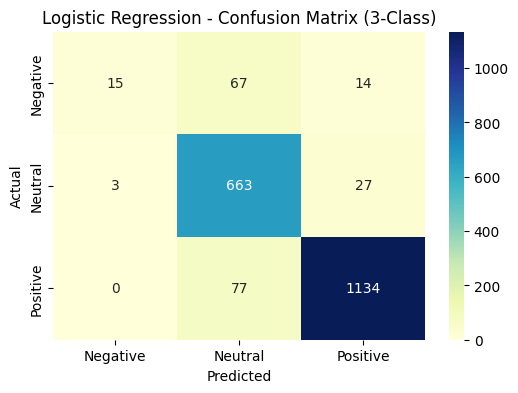


SVM (Linear) Classification Report:
              precision    recall  f1-score   support

    Negative      0.847     0.521     0.645        96
     Neutral      0.869     0.951     0.908       693
    Positive      0.970     0.948     0.959      1211

    accuracy                          0.928      2000
   macro avg      0.896     0.807     0.838      2000
weighted avg      0.930     0.928     0.926      2000



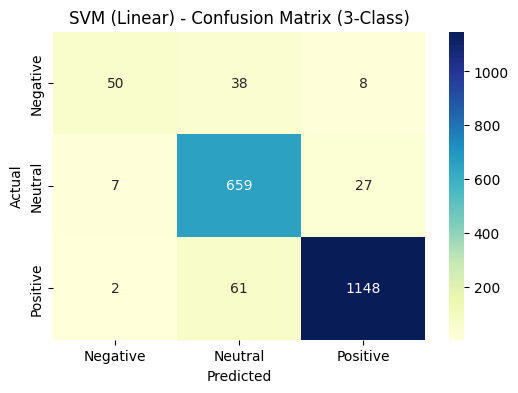


Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative      0.923     0.375     0.533        96
     Neutral      0.871     0.939     0.904       693
    Positive      0.956     0.959     0.958      1211

    accuracy                          0.924      2000
   macro avg      0.917     0.758     0.798      2000
weighted avg      0.925     0.924     0.919      2000



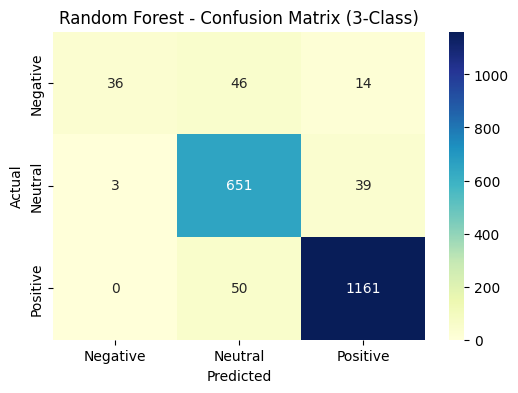

In [ ]:
# 1. Re-map sentiment to integer labels (3 classes)
df['sentiment_label'] = df['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})
X = df['cleaned_content']
y = df['sentiment_label']

# 2. TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(X)

# 3. Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 4. Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Labels for reporting
labels = ['Negative', 'Neutral', 'Positive']

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix (3-Class)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Map score to sentiment classes: 0 = negative, 1 = neutral, 2 = positive
def map_sentiment(score):
    if score <= 2:
        return 0
    elif score == 3:
        return 1
    else:
        return 2

df['sentiment'] = df['score'].apply(map_sentiment)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['content'], df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42
)

# TF-IDF + Random Forest Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000)),
    ('clf', RandomForestClassifier(random_state=42))
])

# Grid Search parameters (light for faster runtime)
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, None]
}

# Run GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate the best model
y_pred = grid.predict(X_test)
print("✅ Best Parameters:", grid.best_params_)
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best Parameters: {'clf__max_depth': None, 'clf__n_estimators': 200}

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.17      0.26       320
           1       0.00      0.00      0.00        85
           2       0.82      0.98      0.89      1595

    accuracy                           0.81      2000
   macro avg       0.45      0.38      0.39      2000
weighted avg       0.74      0.81      0.75      2000



In [ ]:
import spacy
from collections import defaultdict
import pandas as pd

nlp = spacy.load("en_core_web_sm")

# Dictionary to collect aspects and polarity values
aspect_sentiments = defaultdict(list)

# Loop through each review
for idx, row in df.iterrows():
    doc = nlp(row['cleaned_content'])
    for chunk in doc.noun_chunks:
        aspect = chunk.text.lower().strip()
        if 1 < len(aspect.split()) <= 3:  # Only meaningful short phrases
            aspect_sentiments[aspect].append(row['polarity'])

# Convert to DataFrame
aspect_df = pd.DataFrame({
    'aspect': list(aspect_sentiments.keys()),
    'mean_polarity': [sum(pols)/len(pols) for pols in aspect_sentiments.values()],
    'mentions': [len(pols) for pols in aspect_sentiments.values()]
})

# Filter aspects with at least 10 mentions
aspect_df = aspect_df[aspect_df['mentions'] >= 10]
aspect_df.sort_values(by='mean_polarity', ascending=False, inplace=True)

# Display results
print("🔥 Top 10 Positive Aspects:")
print(aspect_df.head(10))

print("\n❄️ Top 10 Negative Aspects:")
print(aspect_df.tail(10))


🔥 Top 10 Positive Aspects:
              aspect  mean_polarity  mentions
16          best app       0.906994       136
446      awesome app       0.896655        20
134    very good app       0.856137        56
43         great app       0.749063       193
285    very nice app       0.705698        29
335        good apps       0.687727        40
49          good app       0.677181       206
625  good experience       0.673561        11
103  really good app       0.614000        10
48         nice apps       0.600000        26

❄️ Top 10 Negative Aspects:
               aspect  mean_polarity  mentions
182      viral videos       0.190196        12
879   trickster voice       0.180000        10
221    tiktok account       0.155472        15
83        tiktok team       0.150522        34
454       new account       0.089486        11
140  dear tiktok team       0.089090        22
195     viral account       0.078610        17
127       viral video       0.051653        14
11          no 

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Define TF-IDF features and labels
X = df['cleaned_content']
y = df['sentiment_label']
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# Define classifier dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (Linear)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score, average='macro')

# Cross-validation loop
for name, model in models.items():
    scores = cross_val_score(model, X_tfidf, y, cv=skf, scoring=scorer)
    print(f"{name} - Macro F1 Scores: {scores}")
    print(f"{name} - Mean F1: {scores.mean():.3f}, Std: {scores.std():.3f}")


Logistic Regression - Macro F1 Scores: [0.72590483 0.71791993 0.73001935 0.71595886 0.69506636]
Logistic Regression - Mean F1: 0.717, Std: 0.012
SVM (Linear) - Macro F1 Scores: [0.83167718 0.78547081 0.81566907 0.81472148 0.78826033]
SVM (Linear) - Mean F1: 0.807, Std: 0.018
Random Forest - Macro F1 Scores: [0.77671738 0.8007345  0.77702667 0.8107822  0.77098596]
Random Forest - Mean F1: 0.787, Std: 0.016


Deep Learning Models: BiLSTM, CNN for text, and GRU.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout, GRU
from sklearn.metrics import classification_report

df = pd.read_csv('tiktok_google_play_reviews.csv')[['content', 'score']]
df.dropna(inplace=True)
df = df.head(10000)  # limit to first 10,000 rows

# Convert score to sentiment labels
def score_to_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['score'].apply(score_to_sentiment)

# Prepare text and labels
X = df['content'].astype(str).values
y = df['sentiment'].values

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

vocab_size = len(tokenizer.word_index) + 1

# Define models
def build_bilstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
        Bidirectional(LSTM(64)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

def build_gru_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
        GRU(64),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    return model

# Train and evaluate
def train_and_evaluate(model, name):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(f"\nTraining {name}...")
    model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_split=0.1, verbose=1)
    preds = model.predict(X_test_pad)
    preds_label = np.argmax(preds, axis=1)
    true_label = np.argmax(y_test, axis=1)
    print(f"\n{name} Classification Report:\n")
    print(classification_report(true_label, preds_label, target_names=le.classes_))

# Run all models
models = {
    'BiLSTM': build_bilstm_model(),
    'CNN': build_cnn_model(),
    'GRU': build_gru_model()
}

for model_name, model in models.items():
    train_and_evaluate(model, model_name)


In [ ]:
pip install transformers datasets scikit-learn pandas numpy torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 844.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Transformers: BERT, DistilBERT, and RoBERTa.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset

# 1. Load and prepare dataset
df = pd.read_csv('tiktok_google_play_reviews.csv')[['content', 'score']]
df.dropna(inplace=True)
df = df.head(1000)  # ✅ Limit to 5,000 samples

# 2. Map scores to sentiment labels
def score_to_sentiment(score):
    if score <= 2:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['score'].apply(score_to_sentiment)

# 3. Encode sentiments
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # Negative:0, Neutral:1, Positive:2

# 4. Train/test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'].astype(str).tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# 5. Wrap in Hugging Face Dataset format
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

# 6. Tokenization function
def tokenize(batch, tokenizer):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

# 7. Generic training function for transformer models
def train_transformer(model_name, label_list):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenize datasets
    train_tok = train_dataset.map(lambda x: tokenize(x, tokenizer), batched=True)
    val_tok = val_dataset.map(lambda x: tokenize(x, tokenizer), batched=True)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))

    # Define training arguments with speed optimizations
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name.replace("/", "_")}',
        num_train_epochs=2,
        max_steps=100,  # ✅ Further reduced for smaller data
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        eval_strategy="epoch",
        save_strategy="no",
        logging_dir='./logs',
        logging_steps=20,
        load_best_model_at_end=False,
        report_to="none"
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        tokenizer=tokenizer
    )

    # Train
    trainer.train()

    # Evaluate
    preds = trainer.predict(val_tok)
    pred_labels = np.argmax(preds.predictions, axis=1)
    print(f"\n=== {model_name} Classification Report ===\n")
    print(classification_report(val_labels, pred_labels, target_names=label_list))

# 8. Train BERT, DistilBERT, RoBERTa
models = {
    'bert-base-uncased': 'BERT',
    'distilbert-base-uncased': 'DistilBERT',
    'roberta-base': 'RoBERTa'
}

for model_name, label in models.items():
    train_transformer(model_name, le.classes_)


/tmp/ipython-input-1-4095425616.py:18: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tiktok_google_play_reviews.csv')[['content', 'score']]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-4095425616.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.661300,0.526157
2,0.573700,0.514332
3,0.430800,0.524382
4,0.351100,0.553816



=== bert-base-uncased Classification Report ===

              precision    recall  f1-score   support

    Negative       0.41      0.23      0.29        31
     Neutral       0.00      0.00      0.00         7
    Positive       0.85      0.96      0.90       162

    accuracy                           0.81       200
   macro avg       0.42      0.39      0.40       200
weighted avg       0.75      0.81      0.77       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-4095425616.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.670100,0.536668
